In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def load_data(datadir):
    img_array = []
    path = os.path.join(datadir)
    path_list = list(os.listdir(path))
    for img in path_list:
        img_array.append(cv2.imread(os.path.join(path, img)))
    return img_array

imgs_data_segmentacao = load_data('bd_size')
imgs_data_segmentacao_label = load_data('bd_size_out')

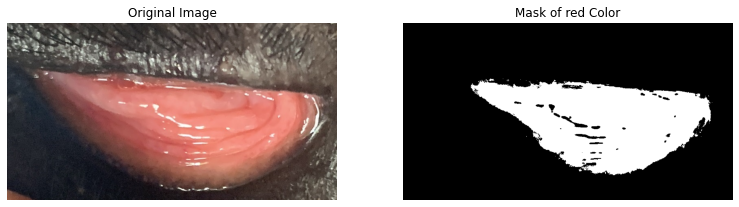

In [8]:
image = imgs_data_segmentacao[9] 
# Converting the image to hsv
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 
# define range of red color in HSV
lower_red = np.array([0,75,180])
upper_red = np.array([255,255,255])
     
# Threshold the HSV image using inRange function to get only red colors
mask = cv2.inRange(hsv, lower_red, upper_red)
 
plt.figure(figsize=[13,13])
plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image",fontdict={'fontsize': 12});plt.axis('off');
plt.subplot(122);plt.imshow(mask, cmap='gray');plt.title("Mask of red Color",fontdict={'fontsize': 12});plt.axis('off');

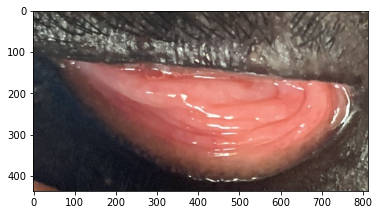

In [9]:
#img = cv2.resize(imgs_data_segmentacao[5],(255,253))
#image = cv2.resize(image,(128,128))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

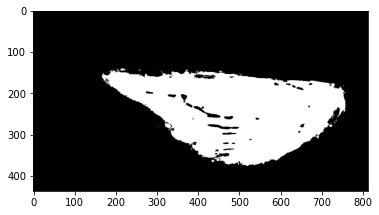

In [10]:
plt.imshow(mask, cmap='gray')

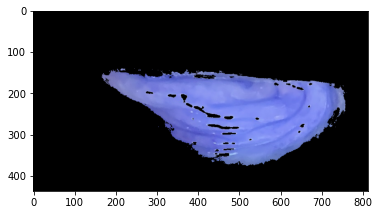

In [11]:
replacedImage = cv2.bitwise_and(image,image, mask = mask)
img2 = cv2.cvtColor(replacedImage, cv2.COLOR_BGR2RGB)
plt.imshow(img2)

In [12]:
kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) # elipse/circular
dilate_ellipse = cv2.dilate(mask,kernel_ellipse,iterations = 1)

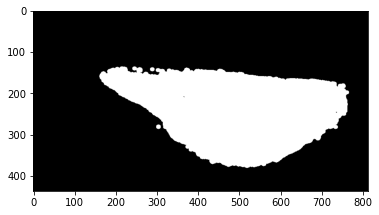

In [13]:
plt.imshow(dilate_ellipse, cmap='gray')

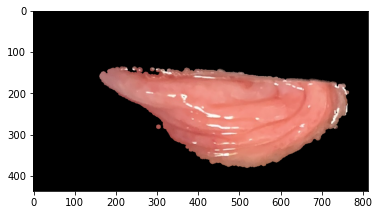

In [38]:
replacedImage2 = cv2.bitwise_and(image,image, mask = dilate_ellipse)
plt.imshow(replacedImage2)

In [21]:
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2959 sha256=c372148a4e78f48c4a6f89b87490f4cbdbf47bebed714e1b7d0f5316637d6092
  Stored in directory: c:\users\andressa.moreira\appdata\local\pip\cache\wheels\f8\e0\3d\9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn


In [39]:
from sklearn.metrics import jaccard_score
img_true=np.array(image).ravel()
img_pred=np.array(replacedImage2).ravel()
#average : string, [None, ‘binary’ (default), ‘micro’, ‘macro’, ‘samples’, ‘weighted’]
jaccard_score(img_true, img_pred, pos_label = "PAIDOFF", average='macro')

C:\Users\andressa.moreira\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'PAIDOFF') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


0.4239590518251366

In [10]:
contours, hierarchy = cv2.findContours(dilate_ellipse, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [11]:
def getGreaterArea(contours):
    arealist = []
    for index in contours:
        area = cv2.contourArea(index)
        arealist.append(area)
    return arealist.index(max(arealist))
index = getGreaterArea(contours)

In [12]:
def segmentationROI(imgOri, Mask, cnt, index):
    #((x_center,y_center)(Width, Height),angle [info: https://namkeenman.wordpress.com/tag/minarearect/])
    rect = cv2.minAreaRect(cnt[index]) 
    #Creation windows for crop return 4 location (x,y), int convert 
    box = np.int0(cv2.boxPoints(rect))
                
    W = rect[1][0] 
    H = rect[1][1]

    #Separating locations    
    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]

    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    rotated = False
    angle = rect[2]

    if angle < -45:
        angle+=90
        rotated = True

    center = (int(rect[0][0]), int(rect[0][1]))
    size = (int(x2-x1),int(y2-y1))

    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

    cropped = cv2.getRectSubPix(imgOri, size, center)    
    cropped = cv2.warpAffine(cropped, M, size)

    croppedMask = cv2.getRectSubPix(Mask, size, center)    
    croppedMask = cv2.warpAffine(croppedMask, M, size)

    croppedW = W if not rotated else H 
    croppedH = H if not rotated else W

    croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW), int(croppedH)), (size[0]/2, size[1]/2))
    croppedRotatedMask = cv2.getRectSubPix(croppedMask, (int(croppedW), int(croppedH)), (size[0]/2, size[1]/2))

    return croppedRotated, croppedRotatedMask
croppedRotated, croppedRotatedMask = segmentationROI(replacedImage, dilate_ellipse, contours, index)

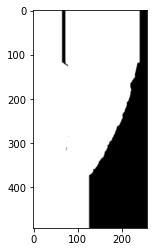

In [13]:
plt.imshow(croppedRotatedMask, cmap='gray')

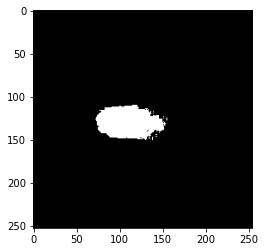

In [42]:
label = cv2.cvtColor(imgs_data_segmentacao_label[3], cv2.COLOR_BGR2GRAY)
#cv2.imshow('label',label)
label = label > 127
label = (label * 255).astype(np.uint8)
plt.imshow(label, cmap='gray')

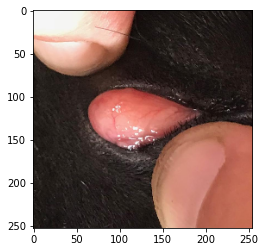

In [50]:
img = cv2.resize(imgs_data_segmentacao[5],(255,253))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [51]:
print(label.shape)
print(img.shape)

(253, 255)
(253, 255, 3)


In [52]:
replacedImage = cv2.bitwise_and(img,img, mask = label)

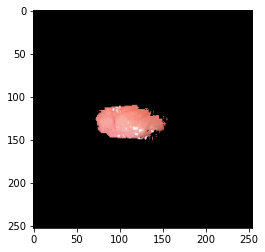

In [54]:
img3 = cv2.cvtColor(replacedImage, cv2.COLOR_BGR2RGB)
plt.imshow(replacedImage)

In [61]:
from sklearn.metrics import jaccard_score
img_true=np.array(img).ravel()
img_pred=np.array(replacedImage).ravel()
#average : string, [None, ‘binary’ (default), ‘micro’, ‘macro’, ‘samples’, ‘weighted’]
jaccard_score(img_true, img_pred, pos_label = "PAIDOFF", average='macro')

C:\Users\andressa.moreira\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1370: UserWarning: Note that pos_label (set to 'PAIDOFF') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


0.09031633997996968